In [14]:
import cv2
import numpy as np
# from matplotlib import pyplot as plt

# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=-100):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    #alpha = 255 / (maximum_gray - minimum_gray)
    #beta = -minimum_gray * alpha
    alpha = .5 # Simple contrast control
    beta = 0   # Simple brightness control
    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

image = cv2.imread('m.jpg')
auto_result, alpha, beta = automatic_brightness_and_contrast(image)
print('alpha', alpha)
print('beta', beta)
cv2.imshow('auto_result', auto_result)
cv2.imwrite('auto_result.png', auto_result)
cv2.imshow('image', image)
cv2.waitKey()

alpha 0.5
beta 0


-1

C:\Users\JO\anaconda3\lib\site-packages\numpy\lib\function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\JO\anaconda3\lib\site-packages\numpy\lib\function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


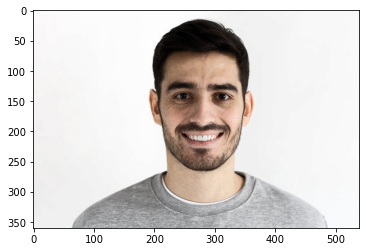

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import imageio
import scipy, scipy.signal
import cv2


def build_is_hist(img):
    hei = img.shape[0]
    wid = img.shape[1]
    ch = img.shape[2]
    Img = np.zeros((hei+4, wid+4, ch))
    for i in range(ch):
        Img[:,:,i] = np.pad(img[:,:,i], (2,2), 'edge')
    hsv = (matplotlib.colors.rgb_to_hsv(Img))
    hsv[:,:,0] = hsv[:,:,0] * 255
    hsv[:,:,1] = hsv[:,:,1] * 255
    hsv[hsv>255] = 255
    hsv[hsv<0] = 0
    hsv = hsv.astype(np.uint8).astype(np.float64)
    fh = np.array([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
    fv = fh.conj().T
    
    H = hsv[:,:,0]
    S = hsv[:,:,1]
    I = hsv[:,:,2]

    dIh = scipy.signal.convolve2d(I, np.rot90(fh, 2), mode='same')
    dIv = scipy.signal.convolve2d(I, np.rot90(fv, 2), mode='same')
    dIh[dIh==0] = 0.00001
    dIv[dIv==0] = 0.00001
    dI = np.sqrt(dIh**2+dIv**2).astype(np.uint32)
    di = dI[2:hei+2,2:wid+2]
    
    dSh = scipy.signal.convolve2d(S, np.rot90(fh, 2), mode='same')
    dSv = scipy.signal.convolve2d(S, np.rot90(fv, 2), mode='same')
    dSh[dSh==0] = 0.00001
    dSv[dSv==0] = 0.00001
    dS = np.sqrt(dSh**2+dSv**2).astype(np.uint32)
    ds = dS[2:hei+2,2:wid+2]

    
    h = H[2:hei+2,2:wid+2]
    s = S[2:hei+2,2:wid+2]
    i = I[2:hei+2,2:wid+2].astype(np.uint8)
    
    Imean = scipy.signal.convolve2d(I,np.ones((5,5))/25, mode='same')
    Smean = scipy.signal.convolve2d(S,np.ones((5,5))/25, mode='same')
    
    Rho = np.zeros((hei+4,wid+4))
    for p in range(2,hei+2):
        for q in range(2,wid+2):
            tmpi = I[p-2:p+3,q-2:q+3]
            tmps = S[p-2:p+3,q-2:q+3]
            corre = np.corrcoef(tmpi.flatten('F'),tmps.flatten('F'))
            Rho[p,q] = corre[0,1]
    
    rho = np.abs(Rho[2:hei+2,2:wid+2])
    rho[np.isnan(rho)] = 0
    rd = (rho*ds).astype(np.uint32)
    Hist_I = np.zeros((256,1))
    Hist_S = np.zeros((256,1))
    
    for n in range(0,255):
        temp = np.zeros(di.shape)
        temp[i==n] = di[i==n]
        Hist_I[n+1] = np.sum(temp.flatten('F'))
        temp = np.zeros(di.shape)
        temp[i==n] = rd[i==n]
        Hist_S[n+1] = np.sum(temp.flatten('F'))

    return Hist_I, Hist_S

def dhe(img, alpha=0.5):
    
    hist_i, hist_s = build_is_hist(img)
    hist_c = alpha*hist_s + (1-alpha)*hist_i
    hist_sum = np.sum(hist_c)
    hist_cum = hist_c.cumsum(axis=0)
    
    hsv = matplotlib.colors.rgb_to_hsv(img)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    i = hsv[:,:,2].astype(np.uint8)
    
    c = hist_cum / hist_sum
    s_r = (c * 255)
    i_s = np.zeros(i.shape)
    for n in range(0,255):
        i_s[i==n] = s_r[n+1]/255.0
    i_s[i==255] = 1
    hsi_o = np.stack((h,s,i_s), axis=2)
    result = matplotlib.colors.hsv_to_rgb(hsi_o)
    
    result = result * 255
    result[result>255] = 255
    result[result<0] = 0
    return result.astype(np.uint8)

def main():
    img_name = 'm.jpg'
    img = imageio.imread(img_name)
    result = dhe(img)
    plt.imshow(result)
    plt.show()

if __name__ == '__main__':
    main()
